<a href="https://www.kaggle.com/code/oscarm524/prediction-interval-eda-modeling-submission?scriptVersionId=155270285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)


<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

- Version 1 (12/04/2023)
    * EDA 
    * Baseline modeling 1.0.
    
    
- Version 2 (12/04/2023)
    * Adding `index = False` to submission file.
    
    
- Version 3 (12/04/2023)
    * Fixing submission error.


- Version 4 (12/06/2023)
    * Updating baseline modeling 1.0.
    
    
- Version 5 (12/06/2023)
    * Fixing bug.
    
    
- Version 6 (12/10/2023)
    * Updating baseline modeling 1.0
    

- Version 7 (12/16/2023)
    * Baseline modeling 2.0 added.

<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
!pip install scikit-lego

  Obtaining dependency information for scikit-lego from https://files.pythonhosted.org/packages/1e/6a/678fe4a17fd3d2ec6de0ad4cb4b020794dcf95fd77e4d8e8532a51ec320f/scikit_lego-0.7.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.1 MB/s eta 0:00:00


In [2]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, median_absolute_error, silhouette_score, accuracy_score, mean_absolute_percentage_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import SGDRegressor, HuberRegressor, RANSACRegressor, LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVR, SVC
from lightgbm import LGBMRegressor, LGBMClassifier, Dataset
import lightgbm as lgb

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklego.linear_model import LADRegression, QuantileRegression

from sklearn.neural_network import MLPRegressor

from category_encoders.target_encoder import TargetEncoder

import sys
sys.path.append('/kaggle/input/winkler-interval-score-metric/')
import MWIS_metric

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [3]:
train = pd.read_csv('../input/prediction-interval-competition-i-birth-weight/train.csv')
train = train.drop(columns = ['id'], axis = 1)

test = pd.read_csv('../input/prediction-interval-competition-i-birth-weight/test.csv')
test = test.drop(columns = ['id'], axis = 1)

submission = pd.read_csv('../input/prediction-interval-competition-i-birth-weight/sample_submission.csv')

print(f"The dimension of the train dataset is {train.shape}")
print(f"The dimension of the test dataset is {test.shape}")

The dimension of the train dataset is (108082, 37)
The dimension of the test dataset is (5689, 36)


In [4]:
train.describe()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DBWT
count,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000
mean,1.330046,1.033891,28.848412,1.557336,10.949048,6.570835,1233.242085,4.055162,39.630447,4.903842,396.380729,751.994809,416.850419,29.004136,1.231260,4.419524,64.302335,0.987398,0.990757,0.685554,1.840316,1.739957,5.274838,13.532670,0.236598,1.290409,0.721665,176.276216,1.796691,1.331582,0.258776,31.566949,3260.113654
std,0.765864,0.310660,12.731588,8.217045,19.837302,3.421184,632.722133,1.855129,22.471849,2.303684,418.051039,326.765441,435.386078,5.804747,0.426245,1.799851,3.755602,0.383417,0.220140,0.464297,1.269902,0.913194,14.986734,14.408799,4.681943,4.100238,5.461285,125.323220,1.166049,0.533019,1.987953,19.113690,589.548274
min,1.000000,1.000000,13.200000,0.000000,1.000000,1.000000,0.000000,1.000000,14.000000,1.000000,3.000000,3.000000,3.000000,12.000000,1.000000,1.000000,48.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,1.000000,1.000000,0.000000,0.000000,227.000000
25%,1.000000,1.000000,22.300000,0.000000,4.000000,4.000000,801.000000,2.000000,28.000000,3.000000,32.000000,888.000000,28.000000,25.000000,1.000000,3.000000,62.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,9.000000,0.000000,0.000000,0.000000,130.000000,1.000000,1.000000,0.000000,20.000000,2965.000000
50%,1.000000,1.000000,25.800000,0.000000,7.000000,7.000000,1238.000000,4.000000,33.000000,4.000000,83.000000,888.000000,80.000000,29.000000,1.000000,4.000000,64.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,12.000000,0.000000,1.000000,0.000000,150.000000,1.000000,1.000000,0.000000,30.000000,3300.000000
75%,1.000000,1.000000,31.200000,0.000000,10.000000,10.000000,1735.000000,6.000000,38.000000,6.000000,888.000000,888.000000,888.000000,33.000000,1.000000,6.000000,66.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,14.000000,0.000000,2.000000,1.000000,182.000000,3.000000,2.000000,0.000000,40.000000,3629.000000
max,9.000000,9.000000,99.900000,99.000000,99.000000,12.000000,9999.000000,7.000000,99.000000,9.000000,999.000000,999.000000,999.000000,50.000000,3.000000,9.000000,99.000000,9.000000,9.000000,1.000000,9.000000,9.000000,99.000000,99.000000,99.000000,99.000000,99.000000,999.000000,9.000000,4.000000,99.000000,99.000000,6840.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108082 entries, 0 to 108081
Data columns (total 37 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ATTEND       108082 non-null  int64  
 1   BFACIL       108082 non-null  int64  
 2   BMI          108082 non-null  float64
 3   CIG_0        108082 non-null  int64  
 4   DLMP_MM      108082 non-null  int64  
 5   DMAR         108082 non-null  object 
 6   DOB_MM       108082 non-null  int64  
 7   DOB_TT       108082 non-null  int64  
 8   DOB_WK       108082 non-null  int64  
 9   FAGECOMB     108082 non-null  int64  
 10  FEDUC        108082 non-null  int64  
 11  ILLB_R       108082 non-null  int64  
 12  ILOP_R       108082 non-null  int64  
 13  ILP_R        108082 non-null  int64  
 14  LD_INDL      108082 non-null  object 
 15  MAGER        108082 non-null  int64  
 16  MBSTATE_REC  108082 non-null  int64  
 17  MEDUC        108082 non-null  int64  
 18  M_Ht_In      108082 non-

In [6]:
test.describe()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN
count,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.00000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000
mean,1.316576,1.032870,28.753436,1.691510,11.009492,6.530322,1232.954825,4.041132,39.593602,4.930568,394.111267,743.494287,411.079979,29.113728,1.234312,4.421867,64.256811,0.984883,0.988926,0.688346,1.851644,1.741079,5.229390,13.592371,0.34347,1.343821,0.817543,174.197223,1.802074,1.329056,0.250132,31.785551
std,0.756227,0.294957,12.308691,9.182817,20.002485,3.442337,638.686470,1.841389,22.324832,2.293802,417.490259,333.515429,434.616045,5.764260,0.427324,1.815095,3.725407,0.358908,0.221197,0.463210,1.288731,0.894546,14.967826,14.597577,5.71272,4.508616,6.181113,117.551599,1.163886,0.535322,1.445753,19.309523
min,1.000000,1.000000,13.900000,0.000000,1.000000,1.000000,0.000000,1.000000,15.000000,1.000000,3.000000,6.000000,3.000000,13.000000,1.000000,1.000000,30.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,75.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,22.300000,0.000000,4.000000,4.000000,800.000000,3.000000,28.000000,3.000000,33.000000,888.000000,28.000000,25.000000,1.000000,3.000000,62.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,9.000000,0.00000,0.000000,0.000000,130.000000,1.000000,1.000000,0.000000,20.000000
50%,1.000000,1.000000,25.800000,0.000000,7.000000,7.000000,1244.000000,4.000000,33.000000,4.000000,82.000000,888.000000,76.000000,29.000000,1.000000,4.000000,64.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,12.000000,0.00000,1.000000,0.000000,150.000000,1.000000,1.000000,0.000000,30.000000
75%,1.000000,1.000000,31.300000,0.000000,10.000000,10.000000,1728.000000,6.000000,38.000000,6.000000,888.000000,888.000000,888.000000,33.000000,1.000000,6.000000,66.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,14.000000,0.00000,2.000000,1.000000,183.000000,3.000000,2.000000,0.000000,40.000000
max,9.000000,7.000000,99.900000,99.000000,99.000000,12.000000,9999.000000,7.000000,99.000000,9.000000,999.000000,999.000000,999.000000,50.000000,3.000000,9.000000,99.000000,9.000000,9.000000,1.000000,9.000000,9.000000,99.000000,99.000000,99.00000,99.000000,99.000000,999.000000,4.000000,4.000000,99.000000,99.000000


There are no missing values neither in `train` and `test` datasets.

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

Notice that the data exploration is based on the competition dataset. First, we start by visualizing `DBWT`, the variable of interest.

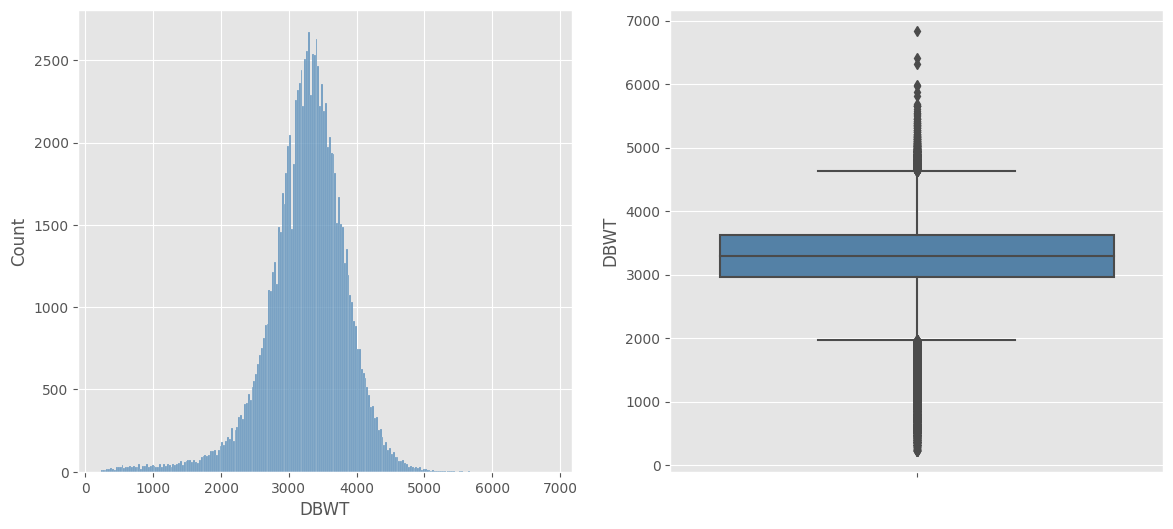

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (14, 6))

sns.histplot(ax = axes[0], data = train, x = 'DBWT', color = 'steelblue');
sns.boxplot(ax = axes[1], data = train, y = 'DBWT', color = 'steelblue');

From the above plots, the distribution of `DBWT` is pretty symmetrical with heavy tails. Next, we explore the relationship between `DBWT` and the categorical features.

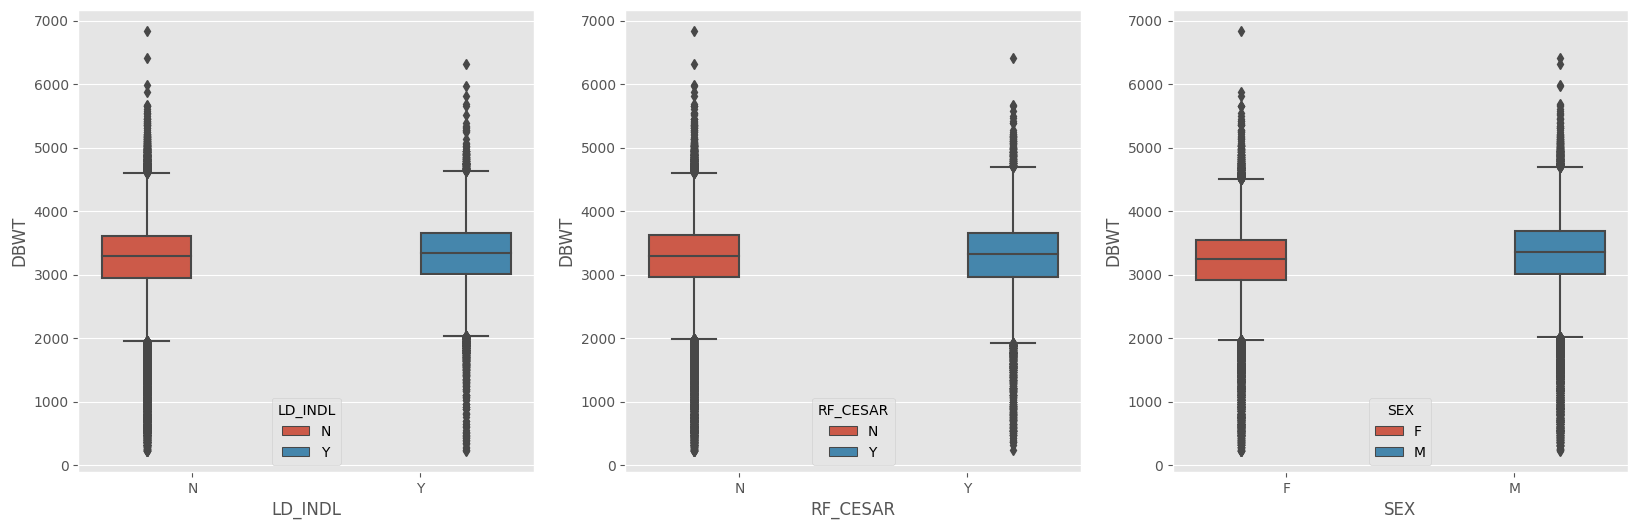

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))

sns.boxplot(ax = axes[0], data = train, y = 'DBWT', x = 'LD_INDL', hue = 'LD_INDL');
sns.boxplot(ax = axes[1], data = train, y = 'DBWT', x = 'RF_CESAR', hue = 'RF_CESAR');
sns.boxplot(ax = axes[2], data = train, y = 'DBWT', x = 'SEX', hue = 'SEX');

From the above charts, we see that the distributions look pretty similar.

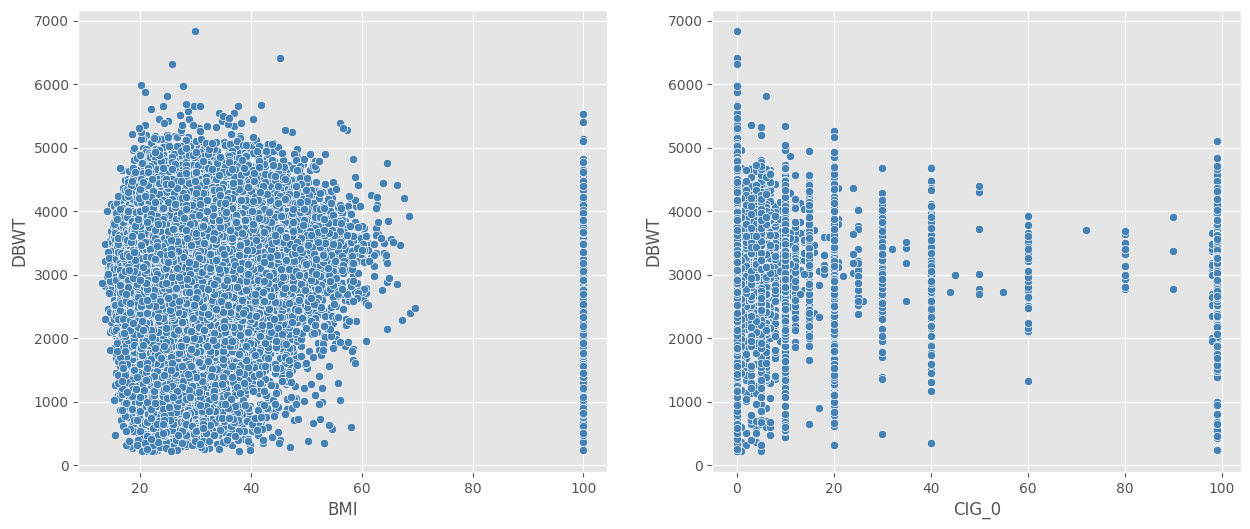

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = train, x = 'BMI', y = 'DBWT', color = 'steelblue');
sns.scatterplot(ax = axes[1], data = train, x = 'CIG_0', y = 'DBWT', color = 'steelblue');

From the above charts, these are a couple of observations:

- In the left panel, there are several observations with `BMI = 99.9`, which seems odd. They may be missing values?
- In the right panel, the pattern is not clear. I was expecting the `DBWT` to decrease as `CIG_0` increases. 

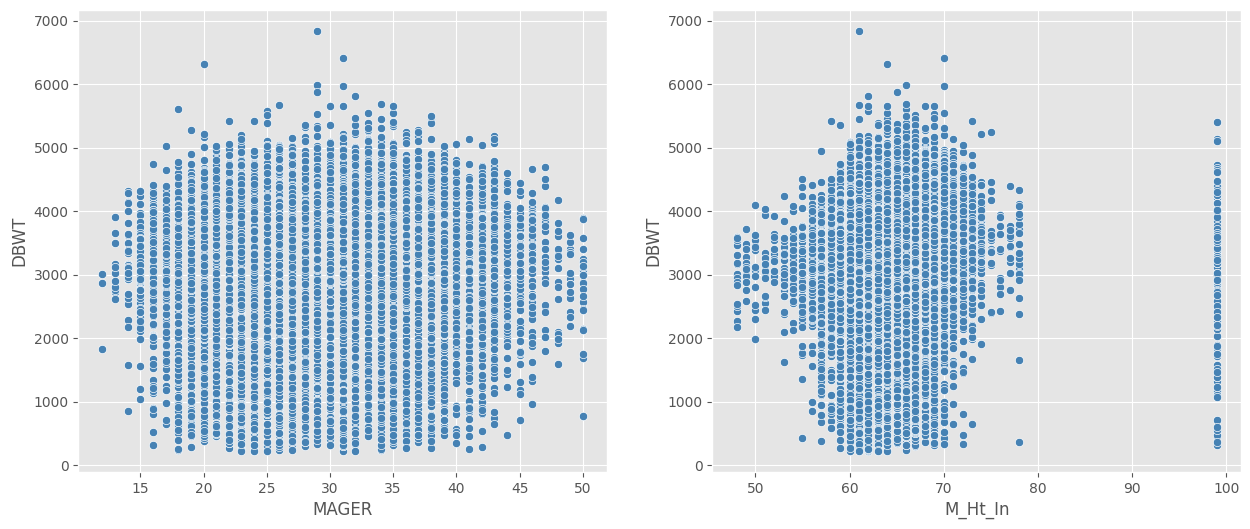

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = train, x = 'MAGER', y = 'DBWT', color = 'steelblue');
sns.scatterplot(ax = axes[1], data = train, x = 'M_Ht_In', y = 'DBWT', color = 'steelblue');

From the above charts, these are a couple of observations:

- In the left panel, there is no clear pattern between mother age and baby's weight.
- In the right panel, there is no clear pattern between mother height and baby's weight. I was expecting an overall positive relationship. Also notice the observations with `M_Ht_In = 99`. I think these observations are missing.

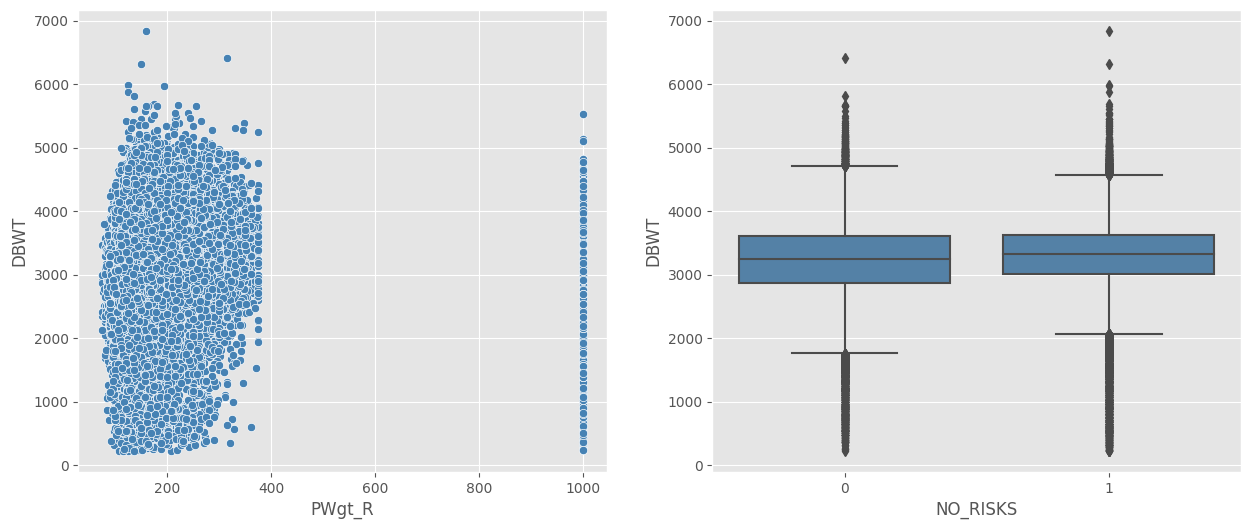

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = train, x = 'PWgt_R', y = 'DBWT', color = 'steelblue');
sns.boxplot(ax = axes[1], data = train, x = 'NO_RISKS', y = 'DBWT', color = 'steelblue');

From the above charts, these are a couple of observations:

- In the left panel, notice the observations with `PWgt_R = 1000`. 
- In the right panel, the distributions of the two groups are very similar.

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We start by modeling the data (with raw data with minimum transformation) using `QuantileRegression`. First, we define the input, target variables and the cross-validation folds.

In [12]:
train = pd.read_csv('../input/prediction-interval-competition-i-birth-weight/train.csv')
train = train.drop(columns = ['id'], axis = 1)
train['LD_INDL'] = train['LD_INDL'].map({'N':0, 'Y': 1})
train['RF_CESAR'] = train['RF_CESAR'].map({'N':0, 'Y': 1})
train['SEX'] = train['SEX'].map({'F':0, 'M': 1})

test = pd.read_csv('../input/prediction-interval-competition-i-birth-weight/test.csv')
test = test.drop(columns = ['id'], axis = 1)
test['LD_INDL'] = test['LD_INDL'].map({'N':0, 'Y': 1})
test['RF_CESAR'] = test['RF_CESAR'].map({'N':0, 'Y': 1})
test['SEX'] = test['SEX'].map({'F':0, 'M': 1})

First, we define the inputs and target features.

In [13]:
X = train.drop(columns = ['DBWT', 'DMAR'], axis = 1)
Y = train['DBWT']

skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 10)

First, we train the `LinearRegression` model.

In [14]:
LR_cv = cross_val_score(make_pipeline(PowerTransformer(), LinearRegression()),
                        X, 
                        Y, 
                        cv = skf,
                        scoring = 'neg_root_mean_squared_error',
                        n_jobs = -1)

print(f"The 10 folds oof RMSE of the LR model is {-1*LR_cv.mean()}")

The 10 folds oof RMSE of the LR model is 559.7256745728953


Next, we train the `Ridge` model.

In [15]:
Ridge_cv = cross_val_score(make_pipeline(PowerTransformer(), Ridge(alpha = 0.01)),
                           X, 
                           Y, 
                           cv = skf,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1)

print(f"The 10 folds oof RMSE of the Ridge model is {-1*Ridge_cv.mean()}")

The 10 folds oof RMSE of the Ridge model is 559.7253309370972


Next, we train the `HistGradientBoostingRegressor` model.

In [16]:
HG_cv = cross_val_score(HistGradientBoostingRegressor(**{'l2_regularization': 0.01,
                                                         'early_stopping': False,
                                                         'learning_rate': 0.1,
                                                         'max_iter': 500,
                                                         'max_depth': 5,
                                                         'max_bins': 255,
                                                         'min_samples_leaf': 16,
                                                         'max_leaf_nodes': 20,
                                                         'random_state': 10}),
                        X, 
                        Y, 
                        cv = skf,
                        scoring = 'neg_root_mean_squared_error',
                        n_jobs = -1)

print(f"The 10 folds oof RMSE of the HG model is {-1*HG_cv.mean()}")

The 10 folds oof RMSE of the HG model is 472.12122531839094


Next, we train the `LGBMRegressor` model.

In [17]:
LGBM_cv = cross_val_score(LGBMRegressor(random_state = 42),
                          X, 
                          Y, 
                          cv = skf,
                          scoring = 'neg_root_mean_squared_error',
                          n_jobs = -1)

print(f"The 10 folds oof RMSE of the LGBM model is {-1*LGBM_cv.mean()}")

The 10 folds oof RMSE of the LGBM model is 513.6730331045017


Next, we train the `XGBRegressor` model.

In [18]:
XGB_cv = cross_val_score(XGBRegressor(**{'max_depth': 6,
                                         'learning_rate': 0.06953797495586428,
                                         'n_estimators': 1000,
                                         'gamma': 2.155188240184727,
                                         'min_child_weight': 44,
                                         'colsample_bytree': 0.4761606769117272,
                                         'subsample': 0.7863463591164056}),
                          X, 
                          Y, 
                          cv = skf,
                          scoring = 'neg_root_mean_squared_error',
                          n_jobs = -1)

print(f"The 10 folds oof RMSE of the XGB model is {-1*XGB_cv.mean()}")

The 10 folds oof RMSE of the XGB model is 474.66650771782935


In [19]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['Linear', 'Ridge', 'Hist', 'LGBM', 'XGBoost']
model_performance['10-folds oof RMSE'] = [-1*LR_cv.mean(), -1*Ridge_cv.mean(), -1*HG_cv.mean(), -1*LGBM_cv.mean(), -1*XGB_cv.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

The followig table shows the performance of the considered models: 

     Model  10-folds oof RMSE
0   Linear         559.725675
1    Ridge         559.725331
2     Hist         472.121225
3     LGBM         513.673033
4  XGBoost         474.666508


Next, we use the top two models to predict `DBWT`.

In [20]:
md4 = HistGradientBoostingRegressor(**{'l2_regularization': 0.01,
                                       'early_stopping': False,
                                       'learning_rate': 0.1,
                                       'max_iter': 500,
                                       'max_depth': 5,
                                       'max_bins': 255,
                                       'min_samples_leaf': 16,
                                       'max_leaf_nodes': 20,
                                       'random_state': 10})

md6 = XGBRegressor(**{'max_depth': 6,
                      'learning_rate': 0.06953797495586428,
                      'n_estimators': 1000,
                      'gamma': 2.155188240184727,
                      'min_child_weight': 44,
                      'colsample_bytree': 0.4761606769117272,
                      'subsample': 0.7863463591164056})

md_preds = pd.DataFrame()
md_preds['md4'] = cross_val_predict(md4, X, Y, cv = skf, n_jobs = -1)
md_preds['md6'] = cross_val_predict(md6, X, Y, cv = skf, n_jobs = -1)

md_preds_test = pd.DataFrame()
md_preds_test['md4'] = md4.fit(X, Y).predict(test.drop(columns = ['DMAR'], axis = 1))
md_preds_test['md6'] = md6.fit(X, Y).predict(test.drop(columns = ['DMAR'], axis = 1))

Next, we run the cross-validation routine to have an idea about `MWIS` and interval coverage.

In [21]:
alpha = 0.1 # the competition alpha
MWIS_scores, coverage_scores = list(), list()

for i, (train_idx, test_idx) in enumerate(skf.split(md_preds, Y)):

    X_train, X_test = md_preds.iloc[train_idx], md_preds.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('----------------------------------------------------------')
    
    q_low = QuantileRegression(quantile = 0.05).fit(X_train, Y_train)
    q_up = QuantileRegression(quantile = 0.95).fit(X_train, Y_train)
    
    predictions = pd.DataFrame()
    predictions['y_true'] = Y_test
    predictions['pi_lower'] = q_low.predict(X_test)
    predictions['pi_upper'] = q_up.predict(X_test)
    
    MWIS, coverage = MWIS_metric.score(predictions['y_true'], predictions['pi_lower'], predictions['pi_upper'], alpha)
    MWIS_scores.append(MWIS)
    coverage_scores.append(coverage)
    
    print('Fold', i, '==> MWI score is ==>', round(MWIS, 3))
    print('Fold', i, '==> Predictions coverage ==>', round(coverage*100, 1),'%')
    
print('\n')
print(f"The average 10-folds oof MWIS score of the linear quantile regressor is {np.mean(MWIS_scores)}")
print(f"The average 10-folds oof coverage of the linear quantile regressor is {np.mean(coverage_scores)}")

----------------------------------------------------------
Fold 0 ==> MWI score is ==> 2030.452
Fold 0 ==> Predictions coverage ==> 89.9 %
----------------------------------------------------------
Fold 1 ==> MWI score is ==> 1998.471
Fold 1 ==> Predictions coverage ==> 90.2 %
----------------------------------------------------------
Fold 2 ==> MWI score is ==> 1978.779
Fold 2 ==> Predictions coverage ==> 90.6 %
----------------------------------------------------------
Fold 3 ==> MWI score is ==> 2006.721
Fold 3 ==> Predictions coverage ==> 90.3 %
----------------------------------------------------------
Fold 4 ==> MWI score is ==> 1999.117
Fold 4 ==> Predictions coverage ==> 90.1 %
----------------------------------------------------------
Fold 5 ==> MWI score is ==> 2025.601
Fold 5 ==> Predictions coverage ==> 89.6 %
----------------------------------------------------------
Fold 6 ==> MWI score is ==> 2044.379
Fold 6 ==> Predictions coverage ==> 89.6 %
---------------------------

Finally, we compute the prediction intervals on the `test` dataset.

In [22]:
q_low = QuantileRegression(quantile = 0.05).fit(md_preds, Y)
q_up = QuantileRegression(quantile = 0.95).fit(md_preds, Y)

submission['pi_lower'] = q_low.predict(md_preds_test)
submission['pi_upper'] = q_up.predict(md_preds_test)
submission.head()

,id,pi_lower,pi_upper
0,108082,2671.653440,4125.659762
1,108083,2367.250164,3935.173022
2,108084,2422.734961,3970.166954
3,108085,2523.436212,4033.983471
4,108086,2325.257394,3916.573341


In [23]:
submission.to_csv('baseline_sub_1.csv', index = False)

<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, we engineer a feature suggested by @paddykb.

In [24]:
def fe(df):
    # calculate the approximate term of pregnancy
    # encode unknown as 0:
    df['approx_term'] = np.where(df['DLMP_MM'] != 99, df['DOB_MM'] - df['DLMP_MM'], 0)
    df['approx_term'] = np.where(df['approx_term'] < 0, df['approx_term'] + 12, df['approx_term'])

    return df

Then, we clean-up the data for modeling purposes.

In [25]:
train = pd.read_csv('../input/prediction-interval-competition-i-birth-weight/train.csv')
train = train.drop(columns = ['id'], axis = 1)
train['LD_INDL'] = train['LD_INDL'].map({'N':0, 'Y': 1})
train['RF_CESAR'] = train['RF_CESAR'].map({'N':0, 'Y': 1})
train['SEX'] = train['SEX'].map({'F':0, 'M': 1})
train['DMAR'] = train['DMAR'].map({'1': 'Married', '2': 'Unmarried', ' ': 'Not_declared'})
train = pd.concat([train.drop(columns = 'DMAR', axis = 1), pd.get_dummies(train['DMAR'], dtype = int).drop(columns = ['Not_declared'], axis = 1)], axis = 1)

test = pd.read_csv('../input/prediction-interval-competition-i-birth-weight/test.csv')
test = test.drop(columns = ['id'], axis = 1)
test['LD_INDL'] = test['LD_INDL'].map({'N':0, 'Y': 1})
test['RF_CESAR'] = test['RF_CESAR'].map({'N':0, 'Y': 1})
test['SEX'] = test['SEX'].map({'F':0, 'M': 1})
test['DMAR'] = test['DMAR'].map({'1': 'Married', '2': 'Unmarried', ' ': 'Not_declared'})
test = pd.concat([test.drop(columns = 'DMAR', axis = 1), pd.get_dummies(test['DMAR'], dtype = int).drop(columns = ['Not_declared'], axis = 1)], axis = 1)

After that, we define the input and target features.

In [26]:
X = train.drop(columns = 'DBWT', axis = 1)
X = fe(X)
Y = train['DBWT']

test = fe(test)
skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 10)

Next, we define the model to predict `DBWT`.

In [27]:
md4 = HistGradientBoostingRegressor(**{'l2_regularization': 0.010152951764677454,
                                       'early_stopping': False,
                                       'learning_rate': 0.03042369803261426,
                                       'max_iter': 722,
                                       'max_depth': 8,
                                       'max_bins': 255,
                                       'min_samples_leaf': 11,
                                       'max_leaf_nodes': 39,
                                       'random_state': 10})

md5 = LGBMRegressor(**{'n_estimators': 1600,
                       'learning_rate': 0.008710832124295645,
                       'max_depth': 11,
                       'reg_alpha': 1.8595699851010477,
                       'reg_lambda': 9.536565717588871,
                       'num_leaves': 99,
                       'subsample': 0.5994903417003732,
                       'colsample_bytree': 0.5396768948739961})

md6 = XGBRegressor(**{'max_depth': 7,
                      'learning_rate': 0.008669916544543348,
                      'n_estimators': 1404,
                      'gamma': 3.9902429923063867,
                      'min_child_weight': 36,
                      'colsample_bytree': 0.495494937289447,
                      'subsample': 0.7740031932962416})

md_preds = pd.DataFrame()
md_preds['md4'] = cross_val_predict(md4, X, Y, cv = skf, n_jobs = -1)
md_preds['md5'] = cross_val_predict(md5, X, Y, cv = skf, n_jobs = -1)
md_preds['md6'] = cross_val_predict(md6, X, Y, cv = skf, n_jobs = -1)

md_preds_test = pd.DataFrame()
md_preds_test['md4'] = md4.fit(X, Y).predict(test)
md_preds_test['md5'] = md5.fit(X, Y).predict(test)
md_preds_test['md6'] = md6.fit(X, Y).predict(test)

Next, we run the cross-validation routine to have an idea about `MWIS` and interval coverage.

In [28]:
alpha = 0.1 # the competition alpha
MWIS_scores, coverage_scores = list(), list()
MWIS_scores_LGBM, coverage_scores_LGBM = list(), list()

for i, (train_idx, test_idx) in enumerate(skf.split(md_preds, Y)):

    X_train, X_test = md_preds.iloc[train_idx], md_preds.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('----------------------------------------------------------')

    ################################
    ## Linear Quantile Regression ##
    ################################
    
    
    q_low = QuantileRegression(quantile = 0.045).fit(X_train, Y_train)
    q_up = QuantileRegression(quantile = 0.955).fit(X_train, Y_train)
    
    predictions = pd.DataFrame()
    predictions['y_true'] = Y_test
    predictions['pi_lower'] = q_low.predict(X_test)
    predictions['pi_upper'] = q_up.predict(X_test)
    
    MWIS, coverage = MWIS_metric.score(predictions['y_true'], predictions['pi_lower'], predictions['pi_upper'], alpha)
    MWIS_scores.append(MWIS)
    coverage_scores.append(coverage)
    
    print('Fold', i, '==> MWI score is ==>', round(MWIS, 3))
    print('Fold', i, '==> Predictions coverage ==>', round(coverage*100, 1),'%')

    ###################
    ## LGBM Quantile ##
    ###################

    LGBM_md_low = LGBMRegressor(objective = 'quantile',
                                alpha = 0.045,
                                random_state = 10).fit(X_train, Y_train)

    LGBM_md_up = LGBMRegressor(objective = 'quantile',
                               alpha = 0.955,
                               random_state = 10).fit(X_train, Y_train)

    predictions = pd.DataFrame()
    predictions['y_true'] = Y_test
    predictions['pi_lower'] = LGBM_md_low.predict(X_test) 
    predictions['pi_upper'] = LGBM_md_up.predict(X_test)

    MWIS, coverage = MWIS_metric.score(predictions['y_true'], predictions['pi_lower'], predictions['pi_upper'], alpha)
    MWIS_scores_LGBM.append(MWIS)
    coverage_scores_LGBM.append(coverage)
    
    print('Fold', i, '==> LGBM MWI score is ==>', round(MWIS, 3))
    print('Fold', i, '==> LGBM Predictions coverage ==>', round(coverage*100, 1),'%')

    
print('\n')
print(f"The average 10-folds oof MWIS score of the LR quantile regressor is {np.mean(MWIS_scores)}")
print(f"The average 10-folds oof coverage of the LR quantile regressor is {np.mean(coverage_scores)}")

print('\n')
print(f"The average 10-folds oof MWIS score of the LGBM quantile regressor is {np.mean(MWIS_scores_LGBM)}")
print(f"The average 10-folds oof coverage of the LGBM quantile regressor is {np.mean(coverage_scores_LGBM)}")

----------------------------------------------------------
Fold 0 ==> MWI score is ==> 2003.143
Fold 0 ==> Predictions coverage ==> 90.6 %
Fold 0 ==> LGBM MWI score is ==> 1995.579
Fold 0 ==> LGBM Predictions coverage ==> 90.1 %
----------------------------------------------------------
Fold 1 ==> MWI score is ==> 1971.813
Fold 1 ==> Predictions coverage ==> 91.3 %
Fold 1 ==> LGBM MWI score is ==> 1965.113
Fold 1 ==> LGBM Predictions coverage ==> 90.6 %
----------------------------------------------------------
Fold 2 ==> MWI score is ==> 1954.171
Fold 2 ==> Predictions coverage ==> 91.4 %
Fold 2 ==> LGBM MWI score is ==> 1944.965
Fold 2 ==> LGBM Predictions coverage ==> 90.9 %
----------------------------------------------------------
Fold 3 ==> MWI score is ==> 1975.521
Fold 3 ==> Predictions coverage ==> 91.3 %
Fold 3 ==> LGBM MWI score is ==> 1972.399
Fold 3 ==> LGBM Predictions coverage ==> 90.5 %
----------------------------------------------------------
Fold 4 ==> MWI score is =

Finally, we compute the prediction intervals on the `test` dataset.

In [29]:
q_low = QuantileRegression(quantile = 0.045).fit(md_preds, Y)
q_up = QuantileRegression(quantile = 0.955).fit(md_preds, Y)

submission['pi_lower'] = q_low.predict(md_preds_test)
submission['pi_upper'] = q_up.predict(md_preds_test)
submission.head()

,id,pi_lower,pi_upper
0,108082,2732.441997,4215.363617
1,108083,2305.857239,3894.112408
2,108084,2324.265307,3903.684465
3,108085,2492.948380,4034.674042
4,108086,2308.753207,3928.890510


In [30]:
submission.to_csv('baseline_sub_2.csv', index = False)

In [31]:
LGBM_md_low = LGBMRegressor(objective = 'quantile',
                            alpha = 0.045,
                            random_state = 10).fit(md_preds, Y)

LGBM_md_up = LGBMRegressor(objective = 'quantile',
                           alpha = 0.955,
                           random_state = 10).fit(md_preds, Y)

submission['pi_lower'] = LGBM_md_low.predict(md_preds_test)
submission['pi_upper'] = LGBM_md_up.predict(md_preds_test)
submission.head()

,id,pi_lower,pi_upper
0,108082,2732.913928,4148.127092
1,108083,2360.881600,3832.645688
2,108084,2374.409793,3938.065497
3,108085,2536.413088,3932.248675
4,108086,2324.870794,3895.437374


In [32]:
submission.to_csv('baseline_sub_3.csv', index = False)